# Rome muncipalities tours

This project is related to the Coursera Capstone Project of the [IBM Data Science specialization course](https://www.coursera.org/professional-certificates/ibm-data-science)

## Main idea

Rome is one of the most visited cities across the World and our intent, as a popular Italian Data Science company, is to develop a tool able to provide some information about the main Rome municipalities, in term of their tourist attractions.

We want to develop a model that exploits the Foresquare location data to measure how the different district are similar or dissimilar in terms of touristic venues. By doing so, the tourist agency will be able to offer a customized and client-based tour across different roman neighborhoods just on the basis of their preferences (for instance, there are persons more interested in museum and cultural activities while other persons are more curious to taste local dishes or even go shopping). 

In practice, the aim of the project can be reformulated in answering the above listed questions, for example:

* If I like going shopping which is the best shopping district?
* If I want to see a lot of Museum and cultural initiatives but at the same time try some local dishes, in which district I should book my Hotel?

## Data

Rome municipalities are 19 and can be found the corresponding [Wikipedia page](https://it.wikipedia.org/wiki/Municipi_di_Roma).

By knowing their name we can retrieve their geospatial coordinates with the ad hoc Python library "Geopy" and then use the GPS coordinates to get some useful informations about the single municipality from the [Foursquare API](https://it.foursquare.com/).

![Rome Municipalities](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Roma_municipi_locator_map_with_roman_numbers.svg/300px-Roma_municipi_locator_map_with_roman_numbers.svg.png)

For each district of Rome we can retrieved from Foursquare API all the venues nearby, with by the "[Get Venue Recommendations](https://developer.foursquare.com/docs/api-reference/venues/explore/)" endpoint .

To limit the number of returned categories not all foursquare API categories will be investigated but only some macro-categories constituring the root of each sub-category such as “food”, “art” and “shopping” and so on. Details on the build-in categories provied by Foursquare can be found [here](https://developer.foursquare.com/docs/build-with-foursquare/categories).

## Exploratory Data Analysis and Methodology

In [1]:
#importing packages needed
import getpass

import requests
import json
from bs4 import BeautifulSoup
from urllib.parse import urlencode

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

#! pip install folium
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
# The code was removed by Watson Studio for sharing.

### Data Processing

In [3]:
def get_category_tree(category, tree={}):
  '''To extract necessary information from Categories API'''
  if not category['categories']:
    return tree

  tree['categories'] = []
  for cat in category['categories']:
    subtree = {
        'id': cat['id'],
        'name': cat['name']
    }
    get_category_tree(cat, subtree)
    tree['categories'].append(subtree)
  return tree

url = 'https://api.foursquare.com/v2/venues/categories?{}'.format(CREDENTIAL_PARAM)
res = requests.get(url).json()["response"]

root = {'name': 'root'}
get_category_tree(res,root)

{'name': 'root',
 'categories': [{'id': '4d4b7104d754a06370d81259',
   'name': 'Arts & Entertainment',
   'categories': [{'id': '56aa371be4b08b9a8d5734db', 'name': 'Amphitheater'},
    {'id': '4fceea171983d5d06c3e9823', 'name': 'Aquarium'},
    {'id': '4bf58dd8d48988d1e1931735', 'name': 'Arcade'},
    {'id': '4bf58dd8d48988d1e2931735', 'name': 'Art Gallery'},
    {'id': '4bf58dd8d48988d1e4931735', 'name': 'Bowling Alley'},
    {'id': '4bf58dd8d48988d17c941735', 'name': 'Casino'},
    {'id': '52e81612bcbc57f1066b79e7', 'name': 'Circus'},
    {'id': '4bf58dd8d48988d18e941735', 'name': 'Comedy Club'},
    {'id': '5032792091d4c4b30a586d5c', 'name': 'Concert Hall'},
    {'id': '52e81612bcbc57f1066b79ef', 'name': 'Country Dance Club'},
    {'id': '52e81612bcbc57f1066b79e8', 'name': 'Disc Golf'},
    {'id': '56aa371be4b08b9a8d573532', 'name': 'Exhibit'},
    {'id': '4bf58dd8d48988d1f1931735', 'name': 'General Entertainment'},
    {'id': '52e81612bcbc57f1066b79ea', 'name': 'Go Kart Track'},
  

In [4]:
def assign_category_mapper(category, mapper={}, parent=None):
    '''To create mapper from a category to its root category'''
    if parent is None:
        parent = category['name']
    mapper[category['name']] = parent
    if category.get('categories'):
        for child in category['categories']:
            assign_category_mapper(child, mapper, parent)
    return mapper

category_mapper = {}
for child in root['categories']:
    assign_category_mapper(child, category_mapper)

def get_category_parent(category, mapper=category_mapper):
    '''To return root category by a given category'''
    return category_mapper.get(category)
category_mapper

{'Arts & Entertainment': 'Arts & Entertainment',
 'Amphitheater': 'Arts & Entertainment',
 'Aquarium': 'Arts & Entertainment',
 'Arcade': 'Arts & Entertainment',
 'Art Gallery': 'Arts & Entertainment',
 'Bowling Alley': 'Arts & Entertainment',
 'Casino': 'Arts & Entertainment',
 'Circus': 'Arts & Entertainment',
 'Comedy Club': 'Arts & Entertainment',
 'Concert Hall': 'Arts & Entertainment',
 'Country Dance Club': 'Arts & Entertainment',
 'Disc Golf': 'Arts & Entertainment',
 'Exhibit': 'Arts & Entertainment',
 'General Entertainment': 'Arts & Entertainment',
 'Go Kart Track': 'Arts & Entertainment',
 'Historic Site': 'Arts & Entertainment',
 'Karaoke Box': 'Arts & Entertainment',
 'Laser Tag': 'Arts & Entertainment',
 'Memorial Site': 'Arts & Entertainment',
 'Mini Golf': 'Arts & Entertainment',
 'Movie Theater': 'Arts & Entertainment',
 'Drive-in Theater': 'Arts & Entertainment',
 'Indie Movie Theater': 'Arts & Entertainment',
 'Multiplex': 'Arts & Entertainment',
 'Museum': 'Arts & 

Let's scrape the Rome municipalities from the web

In [5]:
# Scrape Rome Municipalities from Wikipedia
url = 'https://it.wikipedia.org/wiki/Municipi_di_Roma'
source = requests.get(url).text
soup = BeautifulSoup(source, 'html.parser')
html_table = soup.find("table", {"class": "wikitable sortable"})

municipalities = []
for row in html_table.find_all('a'):
    name = list(row.stripped_strings)
    if name:
        name = name[0]
    else:
        continue
    municipalities.append(name)
    
municipalities=set(municipalities)-set(['PD', 'M5S', 'centrosinistra', 'commissario straordinario', 'km²'])
municipalities=list(municipalities)
municipalities

['III Monte Sacro',
 'I Centro Storico',
 'VII Appio-Latino/Tuscolana/Cinecittà',
 'VI Roma delle Torri',
 'XIV Monte Mario',
 'Virginia Raggi',
 'X Ostia/Acilia',
 'XI Arvalia/Portuense',
 'XII Monte Verde',
 'II Parioli/Nomentano',
 'V Prenestino/Centocelle',
 'IX Eur',
 'IV Tiburtina',
 'VIII Appia Antica',
 'XIII Aurelia',
 'XV Cassia/Flaminia']

In [6]:
# Unfortunately I've to take only the working domains
neighborhoods=["Centro Storico", "Parioli", "Nomentano", "Monte Sacro", "Tiburtina", "Prenestino", "Centocelle", "Appio-Latino","Cinecittà", "Eur", "Portuense", "Monte Mario"]
neighborhoods

['Centro Storico',
 'Parioli',
 'Nomentano',
 'Monte Sacro',
 'Tiburtina',
 'Prenestino',
 'Centocelle',
 'Appio-Latino',
 'Cinecittà',
 'Eur',
 'Portuense',
 'Monte Mario']

In [7]:
def get_nearby_venues(loc_names, origin='', section='', limit=30):

    column_names = ['Municipe',
                    'Latitude',
                    'Longitude']
    df_head = pd.DataFrame(columns=column_names)

    venues_list=[]
    for loc_name in loc_names:

        # create the API request URL
        params = {'near': loc_name + ' ' + origin, 'limit': limit}
        if section:
            params['section'] = section

        url = 'https://api.foursquare.com/v2/venues/explore?{}&{}'.format(
                  CREDENTIAL_PARAM, urlencode(params))

        # make the GET request
        res = requests.get(url).json()["response"]
        center_lat = res['geocode']['center']['lat']
        center_lng = res['geocode']['center']['lng']
        res_venues = res['groups'][0]['items']

        df_head = df_head.append({
            'Municipe': loc_name,
            'Latitude': center_lat,
            'Longitude': center_lng
        }, ignore_index=True)

        venues_list.append([(
            loc_name,
            center_lat,
            center_lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            get_category_parent(v['venue']['categories'][0]['name'])) for v in res_venues])

    df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_venues.columns = ['Municipe',
                         'Latitude',
                         'Longitude',
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

    return (df_head, df_venues)

df_head, df_venues = get_nearby_venues(neighborhoods, origin='Rome', section='')
venue_categories = pd.unique(df_venues['Venue Category']).tolist()

In [8]:
print(df_head.shape)
df_head

(12, 3)


,Municipe,Latitude,Longitude
0,Centro Storico,41.89589,12.48184
1,Parioli,41.92570,12.48770
2,Nomentano,41.91667,12.50000
3,Monte Sacro,41.93333,12.53333
4,Tiburtina,41.93330,12.59890
5,Prenestino,41.89110,12.52650
6,Centocelle,41.88333,12.56667
7,Appio-Latino,41.87122,12.52974
8,Cinecittà,41.85000,12.56667
9,Eur,41.82941,12.46854


In [9]:
print(df_venues.shape)
df_venues.head()

(360, 7)


,Municipe,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro Storico,41.89589,12.48184,Piazza Venezia,41.895747,12.482446,Outdoors & Recreation
1,Centro Storico,41.89589,12.48184,Zuil van Trajanus (Colonna Traiana),41.895816,12.484276,Professional & Other Places
2,Centro Storico,41.89589,12.48184,Terrazza delle Quadrighe,41.894346,12.483336,Outdoors & Recreation
3,Centro Storico,41.89589,12.48184,Palazzo Venezia,41.895965,12.481852,Professional & Other Places
4,Centro Storico,41.89589,12.48184,Palazzo Valentini,41.896691,12.483806,Arts & Entertainment


### Rome Municipalities visualization

In [10]:
# Rome Latitude/Longitude
location = Nominatim(user_agent="trt_explorer").geocode("Rome, IT")
Rome_loc = {'latitude': location.latitude, 'longitude': location.longitude}
Rome_loc

{'latitude': 41.8933203, 'longitude': 12.4829321}

In [11]:
# create map
loc_map = folium.Map(location=[Rome_loc['latitude'], Rome_loc['longitude']],
                     zoom_start=11)

# add borough markers to the map
for lat, lon, name in zip(df_head['Latitude'], df_head['Longitude'], df_head['Municipe']):
    label = folium.Popup(name)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(loc_map)

loc_map

### Venues visualization according to their category

In [12]:
# create map
loc_map = folium.Map(location=[Rome_loc['latitude'], Rome_loc['longitude']],
                     zoom_start=12)

# set color scheme for venue categories
x = np.arange(len(venue_categories))
ys = [i + x + (i*x)**2 for i in range(len(venue_categories))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add venue markers to the map
for lat, lon, name, category in zip(df_venues['Venue Latitude'], df_venues['Venue Longitude'], df_venues['Venue'], df_venues['Venue Category']):
    label = folium.Popup("{} ({})".format(name, category))
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[venue_categories.index(category)],
        opacity=0.7,
        fill=True,
        fill_color=rainbow[venue_categories.index(category)],
        fill_opacity=0.7).add_to(loc_map)

# add borough markers to the map
for lat, lon, name in zip(df_head['Latitude'], df_head['Longitude'], df_head['Municipe']):
    label = folium.Popup(name)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='gray',
        fill_opacity=0.7).add_to(loc_map)

loc_map

### K-means clustering

In [13]:
# One hot encoding
df_loc_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# Add location name column to the first column
df_loc_onehot['Municipe'] = df_venues['Municipe']
fixed_columns = [df_loc_onehot.columns[-1]] + list(df_loc_onehot.columns[:-1])
df_loc_onehot = df_loc_onehot[fixed_columns]

print(df_loc_onehot.shape)
df_loc_onehot.sample(5)

(360, 8)


,Municipe,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
327,Portuense,0,1,0,0,0,0,0
55,Parioli,0,0,0,0,0,1,0
313,Portuense,0,1,0,0,0,0,0
271,Eur,0,0,0,1,0,0,0
105,Monte Sacro,0,1,0,0,0,0,0


In [14]:
# Group venues by boroughs
df_loc_grouped = df_loc_onehot.groupby('Municipe').mean().reset_index()
print(df_loc_grouped.shape)
df_loc_grouped.sample(5)

(12, 8)


,Municipe,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
7,Nomentano,0.100000,0.533333,0.000000,0.166667,0.066667,0.000000,0.133333
4,Eur,0.133333,0.433333,0.066667,0.133333,0.033333,0.166667,0.033333
2,Centro Storico,0.333333,0.266667,0.033333,0.200000,0.166667,0.000000,0.000000
6,Monte Sacro,0.066667,0.633333,0.033333,0.133333,0.000000,0.033333,0.100000
10,Prenestino,0.033333,0.633333,0.233333,0.066667,0.000000,0.033333,0.000000


In [15]:
# Show the most common venues
def return_most_common_venues(row):
    row_categories = row.iloc[1:]    
    return row_categories.sort_values(ascending=False).index.values

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Municipe']
for ind in np.arange(len(venue_categories)):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['Municipe'] = df_loc_grouped['Municipe']

for ind in np.arange(df_loc_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_loc_grouped.iloc[ind, :])

df_venues_sorted.head()

,Municipe,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Appio-Latino,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Arts & Entertainment
1,Centocelle,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Professional & Other Places
2,Centro Storico,Arts & Entertainment,Food,Outdoors & Recreation,Professional & Other Places,Nightlife Spot,Travel & Transport,Shop & Service
3,Cinecittà,Food,Shop & Service,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Arts & Entertainment
4,Eur,Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Professional & Other Places


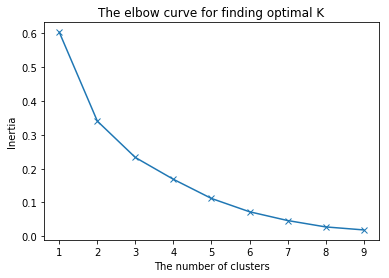

In [16]:
# Find optimal K for K-Mean algorithm
df_loc_grouped_clustering = df_loc_grouped.drop('Municipe', 1)

possible_Ks = np.arange(1,10)
inertia = []
for kcluster in possible_Ks:
    kmeans = KMeans(n_clusters=kcluster, n_init=40, random_state=0).fit(df_loc_grouped_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(possible_Ks, inertia, marker='x')
plt.ylabel('Inertia')
plt.xlabel('The number of clusters')
plt.xticks(possible_Ks)
plt.title('The elbow curve for finding optimal K')
plt.show()

In [17]:
# set optimal number of clusters
kclusters = 4

df_loc_grouped_clustering = df_loc_grouped.drop('Municipe', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=30, random_state=0).fit(df_loc_grouped_clustering)

# add clustering labels
try:
    df_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
except:
    pass
try:
    df_loc_grouped.drop(['Cluster Labels'], axis=1, inplace=True)
except:
    pass
df_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_loc_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_loc_merged = df_head.join(df_venues_sorted.set_index('Municipe'), on='Municipe')
df_loc_merged.sort_values('Cluster Labels')

,Municipe,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
1,Parioli,41.92570,12.48770,0,Food,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,Shop & Service,Nightlife Spot,Professional & Other Places
2,Nomentano,41.91667,12.50000,0,Food,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,Professional & Other Places,Shop & Service,Nightlife Spot
6,Centocelle,41.88333,12.56667,0,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Professional & Other Places
9,Eur,41.82941,12.46854,0,Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Professional & Other Places
8,Cinecittà,41.85000,12.56667,1,Food,Shop & Service,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Arts & Entertainment
3,Monte Sacro,41.93333,12.53333,2,Food,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,Shop & Service,Nightlife Spot,Professional & Other Places
4,Tiburtina,41.93330,12.59890,2,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,Professional & Other Places
5,Prenestino,41.89110,12.52650,2,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places
7,Appio-Latino,41.87122,12.52974,2,Food,Nightlife Spot,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Arts & Entertainment
10,Portuense,41.86905,12.44099,2,Food,Outdoors & Recreation,Shop & Service,Travel & Transport,Nightlife Spot,Professional & Other Places,Arts & Entertainment


## Result visualization

In [18]:
cluster_stats = df_loc_grouped.drop('Municipe', axis=1).groupby('Cluster Labels').mean()
pd.concat([pd.DataFrame({'Count': df_loc_grouped.drop('Municipe', axis=1).groupby('Cluster Labels').count().iloc[:,0]}), cluster_stats], axis=1 )

,Count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Cluster Labels,,,,,,,,
0,4,0.091667,0.466667,0.083333,0.158333,0.033333,0.075000,0.091667
1,1,0.000000,0.600000,0.033333,0.033333,0.033333,0.300000,0.000000
2,6,0.022222,0.688889,0.088889,0.083333,0.000000,0.061111,0.055556
3,1,0.333333,0.266667,0.033333,0.200000,0.166667,0.000000,0.000000


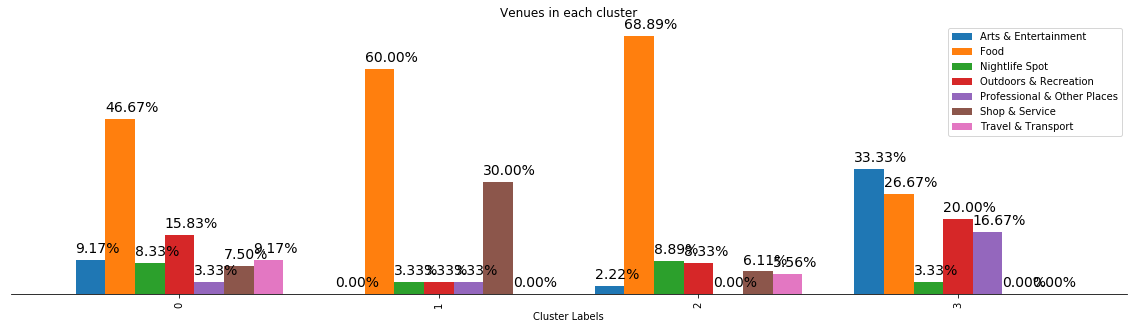

In [19]:
ax = cluster_stats.plot(kind='bar', figsize=(20,5), width=0.8)
ax.get_yaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:
    label = "{:.2f}%".format(p.get_height()*100)
    ax.annotate(label, (p.get_x(), p.get_height() + 0.02), fontsize=14)

plt.title('Venues in each cluster')
plt.show()

In [20]:
# create map
cluster_labels = [
    'Cluster 0 - "Food Lover"',
    'Cluster 1 - "Art and Outdoors Lover"',
    'Cluster 2 - "Food and Shopping Lover"',
    'Cluster 3 -  Nightlife and Food Lover'
]
map_clusters = folium.Map(location=[Rome_loc['latitude'], Rome_loc['longitude']], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(df_loc_merged['Latitude'], df_loc_merged['Longitude'], df_loc_merged['Municipe'], df_loc_merged['Cluster Labels']):
    label = folium.Popup("{} | {}".format(name, cluster_labels[cluster]), max_width=200)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

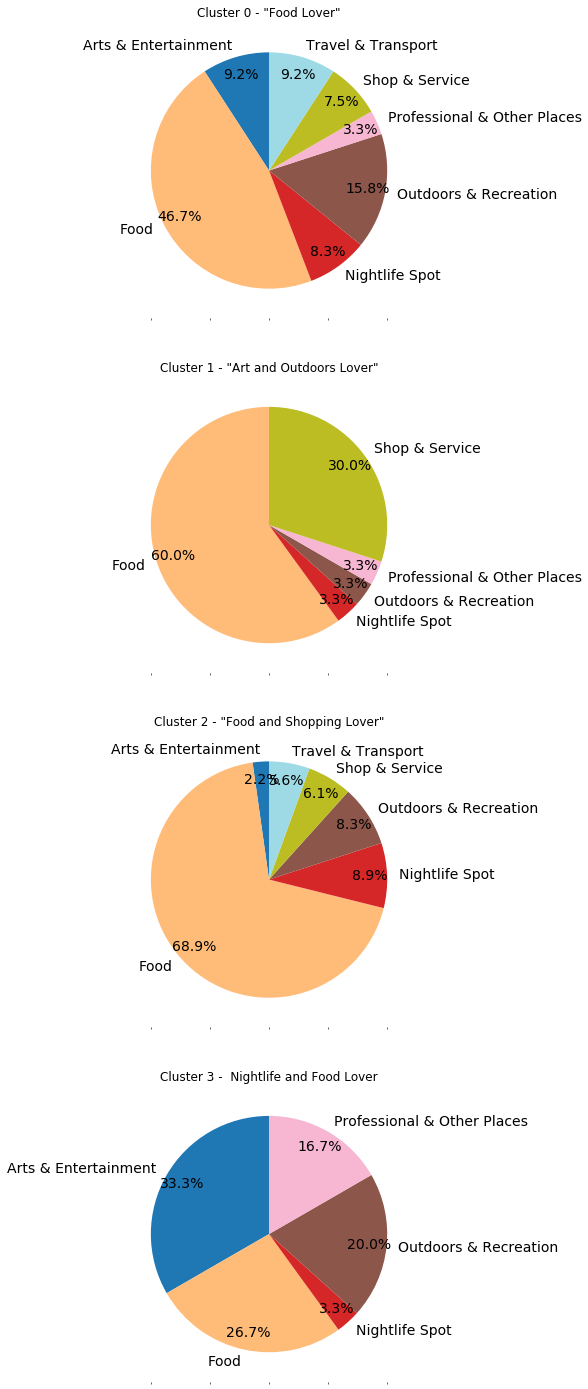

In [21]:
cluster_stats_pie_plot = cluster_stats.transpose()
cluster_stats_pie_plot.columns = ['Cluster ' + str(col) for col in cluster_stats_pie_plot.columns]
axes = cluster_stats_pie_plot.plot(kind='pie',
                                    subplots=True,
                                    figsize=(20,25),
                                    autopct=lambda pct: '{:.1f}%'.format(pct) if pct > 0 else '', 
                                    startangle=90,
                                    pctdistance=0.85,
                                    sort_columns=True,
                                    colormap='tab20',
                                    layout=(kclusters,1),
                                    fontsize=14,
                                    legend=False,
                                    title=[    'Cluster 0 - "Food Lover"',
    'Cluster 1 - "Art and Outdoors Lover"',
    'Cluster 2 - "Food and Shopping Lover"',
    'Cluster 3 -  Nightlife and Food Lover'])
for ax in axes:
    ax[0].axes.get_yaxis().set_visible(False)
plt.show()